#**Otimização de Portfolio** - Projeto FGV Quant

Este projeto tem por objetivo a otimização de carteiras de ações através de minimização de riscos (Sharpe Ratio), utilizando conceitos de Fronteira Eficiente de Markowitz e demais ferramentas.

Autor: **Calebe Soares**

In [ ]:
#Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
!pip install yfinance #biblioteca para importação dos dados das ações
import yfinance as yf
!pip install pyportfolioopt #biblioteca a ser utilzada para otimização da carteira

# Seleção de ativos e plotagem do retorno por cada ação da carteira

Digite quais são os ativos que vão compor sua carteira: cogn3,tasa4,vale3,wege3,azul4
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


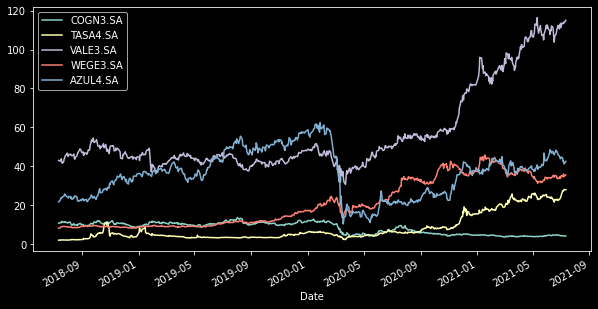

In [128]:
#Seleção de ativos
ativos = input("Digite quais são os ativos que vão compor sua carteira: ").upper().split(",")
ativos = [ticker + ".SA" for ticker in ativos]

#Com as devidas bibliotecas instaladas, agora iremos fazer a composição da carteira pelas ações escolhidas
carteira = pd.DataFrame()
for i in ativos:
  carteira[i] = yf.download(i,period="3y")['Adj Close']

#Visualização dos retornos das ações
plt.style.use('dark_background')
carteira.plot(figsize=(10,5))

# Cálculos do retorno da carteira e a matriz de covariância

In [129]:
#Para a realização da fronteira eficiente, é necessário a realização do retorno esperado e da matriz de covariação
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
er = mean_historical_return(carteira) #Retorno esperado da carteira
sd = CovarianceShrinkage(carteira).ledoit_wolf() #Matriz de covariância
sd

,COGN3.SA,TASA4.SA,VALE3.SA,WEGE3.SA,AZUL4.SA
COGN3.SA,0.366246,0.096160,0.083679,0.089934,0.236428
TASA4.SA,0.096160,0.966033,0.064652,0.046266,0.121083
VALE3.SA,0.083679,0.064652,0.210845,0.050320,0.118325
WEGE3.SA,0.089934,0.046266,0.050320,0.189940,0.129013
AZUL4.SA,0.236428,0.121083,0.118325,0.129013,0.540154


# Alocação da carteira nos ativos de acordo a maximização do Índice de Sharpe  
 Visão geral do retorno esperado da carteira, volatilidade e Sharpe Ratio do portfolio

In [130]:
#Com a matriz de covariação e o retorno esperado das ações da carteira, agora calculamos a porcentagemd e alocação em cada posição da carteira
from pypfopt.efficient_frontier import EfficientFrontier
ef = EfficientFrontier(er,sd)
composicao = ef.max_sharpe(risk_free_rate=0.0425)

#Visão geral
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('COGN3.SA', 0.0), ('TASA4.SA', 0.27733), ('VALE3.SA', 0.13926), ('WEGE3.SA', 0.58341), ('AZUL4.SA', 0.0)])
Expected annual return: 84.2%
Annual volatility: 41.4%
Sharpe Ratio: 1.93


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:412: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  UserWarning,


(0.8419605218246167, 0.4137383199184982, 1.93228541649732)

In [131]:
#Como houveram posições com peso igual a 0, houve o rebalanceamento de modo a ponderar melhor as posições da carteira
from pypfopt import objective_functions

ef = EfficientFrontier(er, sd)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
w = ef.max_sharpe()
ef.clean_weights()

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:253: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('COGN3.SA', 0.0),
             ('TASA4.SA', 0.32683),
             ('VALE3.SA', 0.17661),
             ('WEGE3.SA', 0.49655),
             ('AZUL4.SA', 0.0)])

# Quantidade de ações a serem compradas de acordo com o patrimônio do portfolio

In [132]:
#Quantidade de ações a serem compradas de acordo com o valor de seu portfolio
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
portfolio_value = float(input("Qual o valor do seu portfolio? * Digite apenas o numero, sem vírgulas e pontos *"))
latest_prices = get_latest_prices(carteira)
da = DiscreteAllocation(w, latest_prices, portfolio_value)
allocation, leftover = da.lp_portfolio()
print(allocation)

Qual o valor do seu portfolio? * Digite apenas o numero, sem vírgulas e pontos *10000
{'TASA4.SA': 117, 'VALE3.SA': 15, 'WEGE3.SA': 140}


# Plotagem da fronteria eficiente

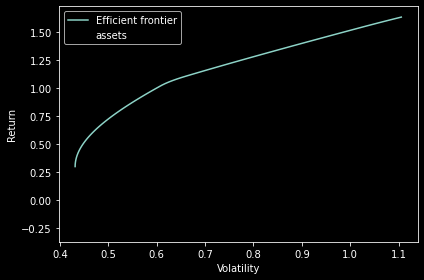

In [133]:
#Plotagem da Fronteira eficiente
from pypfopt import plotting
ef = EfficientFrontier(er, sd, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

# Fronteria eficiente com Índice de Sharpe maximizado e geração de portfolios aleatórios para a fronteira

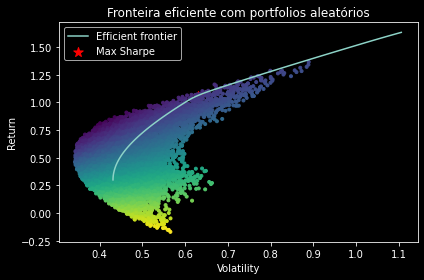

In [134]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Geração de portfolios aleatórios, para a composição da fronteira
n_samples = 10000
w = np.random.dirichlet(np.ones(len(er)), n_samples)
rets = w.dot(er)
stds = np.sqrt(np.diag(w @ sd @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Resultado
ax.set_title("Fronteira eficiente com portfolios aleatórios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

# Backtesting

In [ ]:
!pip install bt

In [193]:
import bt
rebalancing = bt.Strategy("Rebalanceamento",
                          [bt.algos.RunMonthly(run_on_end_of_period=True), 
                           bt.algos.SelectAll(), 
                           bt.algos.WeighSpecified(**composicao), 
                           bt.algos.Rebalance()]
                          )

buyhold = bt.Strategy("Buy & Hold",
                      [bt.algos.RunOnce(), 
                       bt.algos.SelectAll(), 
                       bt.algos.WeighSpecified(**composicao),
                       bt.algos.Rebalance()]
                      )

In [194]:
bt1 = bt.Backtest(rebalancing, carteira, initial_capital=portfolio_value)
bt2 = bt.Backtest(buyhold, carteira, initial_capital=portfolio_value)

In [203]:
results = bt.run(bt1, bt2)

/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [204]:
results.display()

Stat                 Rebalanceamento    Buy & Hold
-------------------  -----------------  ------------
Start                2018-07-11         2018-07-11
End                  2021-07-12         2021-07-12
Risk-free rate       0.00%              0.00%

Total Return         557.86%            575.01%
Daily Sharpe         1.65               1.50
Daily Sortino        2.65               2.45
CAGR                 87.24%             88.85%
Max Drawdown         -45.51%            -48.76%
Calmar Ratio         1.92               1.82

MTD                  8.50%              12.11%
3m                   4.66%              9.55%
6m                   4.79%              15.82%
YTD                  21.11%             32.89%
1Y                   114.89%            128.24%
3Y (ann.)            87.35%             88.96%
5Y (ann.)            -                  -
10Y (ann.)           -                  -
Since Incep. (ann.)  87.24%             88.85%

Daily Sharpe         1.65               1.50
Daily Sor

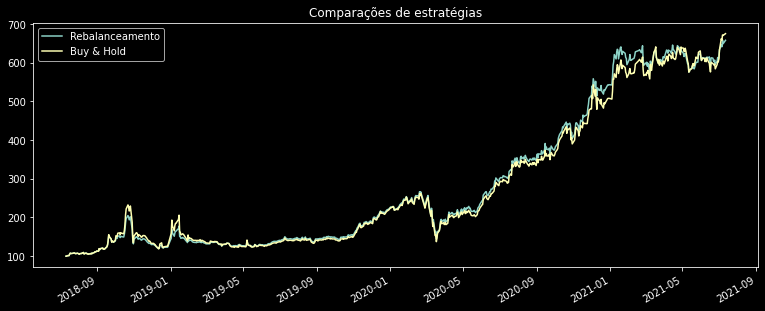

In [205]:
results.plot(title="Comparações de estratégias",figsize=(13,5))

In [206]:
results.get_transactions()

price  quantity
Date       Security                      
2018-07-12 TASA4.SA    2.010000    1379.0
           VALE3.SA   43.027569      32.0
           WEGE3.SA    8.202607     711.0
2018-07-31 TASA4.SA    2.050000      68.0
           VALE3.SA   46.771690      -1.0
...                         ...       ...
2021-05-31 VALE3.SA  112.557213      -4.0
           WEGE3.SA   34.129112      15.0
2021-06-30 TASA4.SA   23.650000      34.0
           VALE3.SA  113.250000      -3.0
           WEGE3.SA   33.689999     -15.0

[107 rows x 2 columns]

In [211]:
results.get_security_weights()

,TASA4.SA,VALE3.SA,WEGE3.SA
2018-07-11,0.000000,0.000000,0.000000
2018-07-12,0.277179,0.137688,0.583205
2018-07-13,0.283237,0.135585,0.579274
2018-07-16,0.276818,0.134278,0.587007
2018-07-17,0.276201,0.131348,0.590621
...,...,...,...
2021-07-05,0.301388,0.129749,0.567368
2021-07-06,0.301947,0.131302,0.565245
2021-07-07,0.296233,0.128156,0.574146
2021-07-08,0.307454,0.129617,0.561440


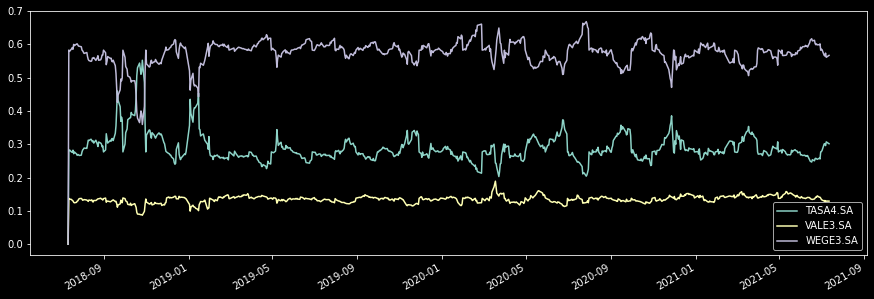

In [218]:
results.plot_security_weights()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

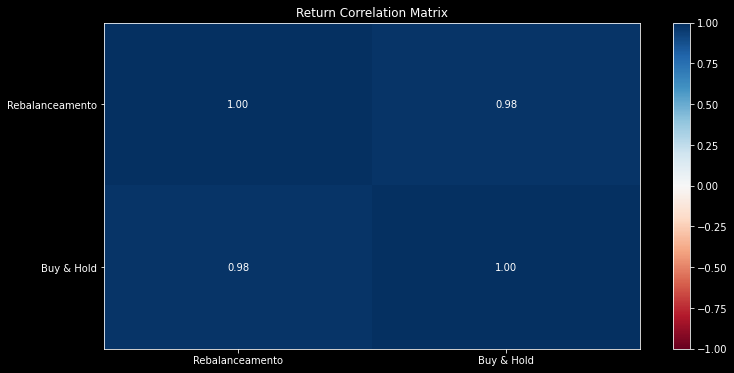

In [216]:
results.plot_correlation()

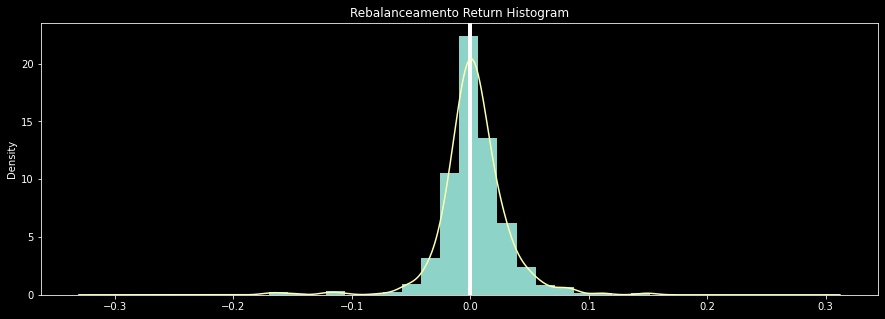

In [217]:
results.plot_histogram()